# Tutorial — Resolución de un problema de difusión 2D con FVM

---

## Modelo matemático

Estamos resolviendo la ecuación de difusión estacionaria en 2D:

$$
\nabla \cdot (\Gamma \nabla \phi) = 0
$$

en el dominio cuadrado:

$$
\Omega = [0,1] \times [0,1]
$$

donde:

* $\phi(x,y)$ es la variable escalar desconocida.
* $\Gamma$ es el coeficiente de difusión (constante en este caso).

Como $\Gamma = 1$, la ecuación se reduce a la ecuación de Laplace:

$$
\nabla^2 \phi = 0
$$

---

## Condiciones de borde

Se imponen condiciones de Dirichlet en los cuatro lados:

| Borde | Condición  |
| ----- | ---------- |
| $x=0$ | $\phi = 0$ |
| $x=1$ | $\phi = 0$ |
| $y=0$ | $\phi = 0$ |
| $y=1$ | $\phi = 1$ |

Físicamente, esto representa:

* Tres paredes a temperatura cero.
* La pared superior a temperatura unitaria.

El problema es puramente difusivo y lineal.

In [11]:
import gmsh
import sys
import numpy as np
from fidelio import *

## Geometría y mallado en gmsh

In [50]:
filename = "square.msh"
lx = 1
ly = 1
nx = 10
ny = 10

order = 1

gmsh.initialize()
gmsh.model.add("unit_square")

# ---------------------------------
# Geometría
# ---------------------------------
p1 = gmsh.model.geo.addPoint(0, 0, 0, lx / nx)
p2 = gmsh.model.geo.addPoint(lx, 0, 0, lx / nx)
p3 = gmsh.model.geo.addPoint(lx, ly, 0, ly / ny)
p4 = gmsh.model.geo.addPoint(0, ly, 0, ly / ny)

l1 = gmsh.model.geo.addLine(p1, p2)
l2 = gmsh.model.geo.addLine(p2, p3)
l3 = gmsh.model.geo.addLine(p3, p4)
l4 = gmsh.model.geo.addLine(p4, p1)

cl = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4])
surface = gmsh.model.geo.addPlaneSurface([cl])

# ---------------------------------
# Physical Groups (fundamental)
# ---------------------------------
gmsh.model.addPhysicalGroup(1, [l1], name="down")
gmsh.model.addPhysicalGroup(1, [l2], name="right")
gmsh.model.addPhysicalGroup(1, [l3], name="up")
gmsh.model.addPhysicalGroup(1, [l4], name="left")
gmsh.model.addPhysicalGroup(2, [surface], name="domain")

gmsh.model.geo.synchronize()

# ---------------------------------
# Mallado
# ---------------------------------
gmsh.model.mesh.generate(2)
gmsh.model.mesh.setOrder(order)

# ASCII formato 2.2 (más simple de parsear)
gmsh.option.setNumber("Mesh.MshFileVersion", 2.2)
gmsh.write(filename)

gmsh.finalize()

## Malla y mapeo de bordes

In [51]:
nodes, tris, boundary_nodes, boundary_edges = read_msh_extract_data("square.msh", gmsh)

mesh = MeshFVM(nodes, tris)  # si ya eliminaste Tessellation

boundary_faces = mesh.build_boundary_face_dict(boundary_edges)

boundary_faces

{'down': array([ 0,  6,  9, 12, 15, 18, 21, 24, 27,  3]),
 'right': array([ 4, 35, 38, 41, 44, 47, 50, 53, 56, 32]),
 'up': array([33, 64, 67, 70, 73, 76, 79, 82, 85, 61]),
 'left': array([ 62,  90,  93,  96,  99, 102, 105, 108, 111,   1])}

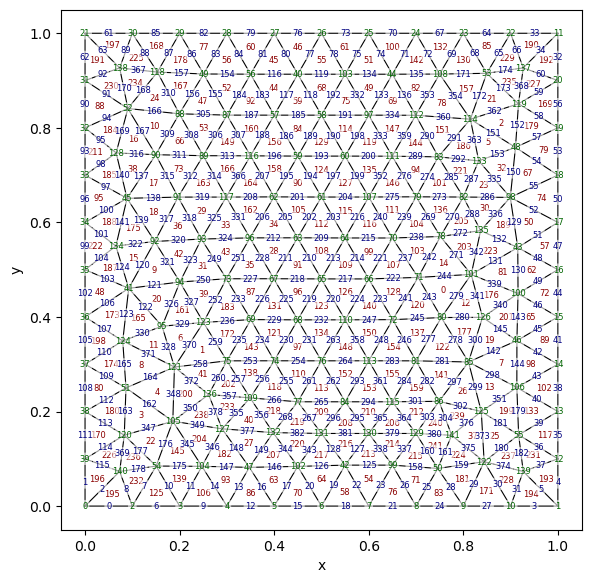

In [53]:
mesh.compute_fvm_geometry()
mesh.plot_topology(
    element_color = "darkred",
    face_color = "navy",
    node_color = "darkgreen",
    element_size = 6,
    face_size = 6,
    node_size = 6,
    figsize = (6, 6)
)

In [54]:
boundary_faces

{'down': array([ 0,  6,  9, 12, 15, 18, 21, 24, 27,  3]),
 'right': array([ 4, 35, 38, 41, 44, 47, 50, 53, 56, 32]),
 'up': array([33, 64, 67, 70, 73, 76, 79, 82, 85, 61]),
 'left': array([ 62,  90,  93,  96,  99, 102, 105, 108, 111,   1])}

## Implementación FVM

In [40]:
p = FVMProblem(mesh)
p.initialize_phi(0.)
p._update_gradients()

## $\Gamma$

In [41]:
def my_gamma(p):
    return np.full(p.Ne, 1.0)
p.gamma_function = my_gamma
p.initialize_gamma()

## Coeficientes de difusión

In [55]:
p.compute_diffusion_coefficients()

## Patch para fronteras

In [57]:
boundary_faces

{'down': array([ 0,  6,  9, 12, 15, 18, 21, 24, 27,  3]),
 'right': array([ 4, 35, 38, 41, 44, 47, 50, 53, 56, 32]),
 'up': array([33, 64, 67, 70, 73, 76, 79, 82, 85, 61]),
 'left': array([ 62,  90,  93,  96,  99, 102, 105, 108, 111,   1])}

In [56]:
p.create_boundary_patches(boundary_faces)

## Condiciones de borde ($S_c$ y $S_p$)

In [45]:
def my_boundary_sources(p):
    Sc = np.zeros(p.Ne)
    Sp = np.zeros(p.Ne)

    patch = p.left
    gamma = p.Gamma_f[patch.faces]
    coeff = gamma * patch.Sf_norm / patch.dCf_norm
    Sp[patch.cells] += coeff
    Sc[patch.cells] += coeff * 0

    patch = p.right
    gamma = p.Gamma_f[patch.faces]
    coeff = gamma * patch.Sf_norm / patch.dCf_norm
    Sp[patch.cells] += coeff
    Sc[patch.cells] += coeff * 0

    patch = p.down
    gamma = p.Gamma_f[patch.faces]
    coeff = gamma * patch.Sf_norm / patch.dCf_norm
    Sp[patch.cells] += coeff
    Sc[patch.cells] += coeff * 0

    patch = p.up
    gamma = p.Gamma_f[patch.faces]
    coeff = gamma * patch.Sf_norm / patch.dCf_norm
    Sp[patch.cells] += coeff
    Sc[patch.cells] += coeff * 1
    return Sc, Sp

In [46]:
p.boundary_sources_function = my_boundary_sources
p.calculate_boundary_sources()

## Ensamblaje y solución 

In [58]:
p.assemble_system()

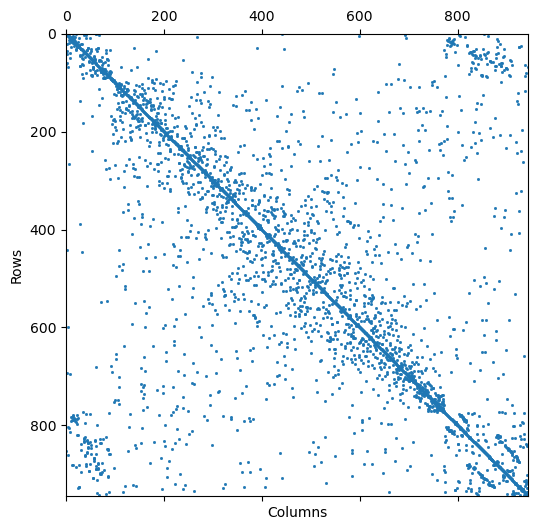

In [62]:
p.plot_matrix_sparsity()

In [59]:
p.solve()

problem solved...


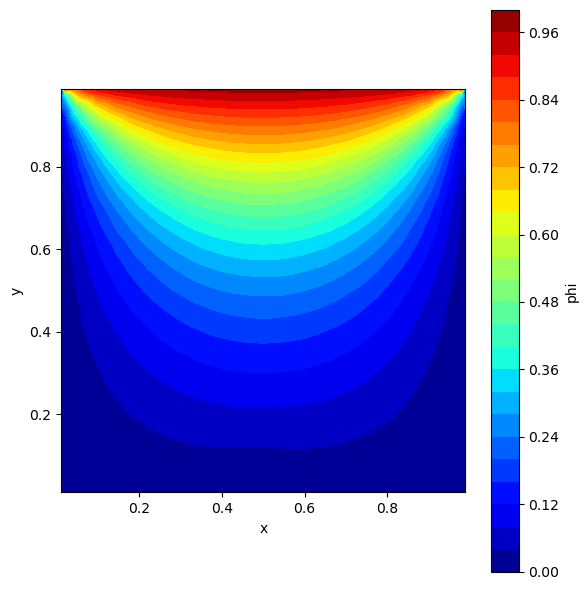

In [60]:
plot_phi_contours(
    p,
    field="cell",
    levels = 30,
    cmap="jet",
    include_internal_faces=False,
    include_boundary_faces=True,
    show_contour_lines=False,
    figsize=(6, 6)
)